## Введение

**Что бизнес хочет измерить:**
1. Деньги
2. Время
3. Товар
4. и тд



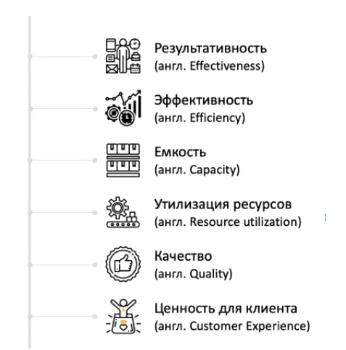

**Что DS хочет измерить:**
1. Процент правильных решений

Нужно как-то эти две вещи связать вместе, т.к. ни одна из функций бизнеса не поможет нам обучать модель.


## Кейс 1 - фильтрация токсичных комментариев

Есть сервис, где люди могут оставлять комментарии

При этом часть комментариев является токсичной, т.е содержит расистские, сексистские и тому подобные вещи.

Над проверкой сообщений работают модераторы и мы хотим уменьшить на них нагрузку с помощью ML.


1. Если владелец данного ресурса не будет избавляться от таких комментариев, то надзор выставляет штраф за нарушение правил
2. Если модератор банит всех подряд за такие сообщения, то пользователи, которых часто банят, уйдут с нашего ресурса и владелец потеряет рекламные деньги


Так что две стороны у этой задачи




Гипотеза.
Мы предполагаем, что автоматическая фильтрация токсичных комментариев снизит нагрузку на модераторов и повысит их пропускную способность на 10%, при этом доля FP не превысит 10%

<img src='https://drive.google.com/uc?export=view&id=1OpoIwLA0-vpWw_D2X9_oyFt6qcXgh8Rw' width=600>

In [1]:
!wget 'https://drive.google.com/uc?&id=1oPtTtVbkSEdiNwjcSHeEkv_C9g0yfLVO' -O train.csv

--2024-04-25 08:14:36--  https://drive.google.com/uc?&id=1oPtTtVbkSEdiNwjcSHeEkv_C9g0yfLVO
Resolving drive.google.com (drive.google.com)... 172.253.115.100, 172.253.115.102, 172.253.115.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.115.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1oPtTtVbkSEdiNwjcSHeEkv_C9g0yfLVO [following]
--2024-04-25 08:14:36--  https://drive.usercontent.google.com/download?id=1oPtTtVbkSEdiNwjcSHeEkv_C9g0yfLVO
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68802655 (66M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  65.62M  92.8MB/s    in 0.7s    

2024-04-25 08:14:41 (92.8 MB/

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
128088,ad1180e693cb3cd5,"""\n\nComment: Please note that while """"liberat...",0,0,0,0,0,0
100545,1a34922e126246ff,"""\nAlso, Zap2it and TV by the Numbers are not ...",0,0,0,0,0,0
119251,7d7ea931d798788d,Gayaza\nIs Gayaza located here? Can we get an...,0,0,0,0,0,0


Здесь много разных вариантов, но мы сведем все к бинарному классу - toxic/nontoxic

In [3]:
train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

y
0    143346
1     16225
Name: count, dtype: int64

Сделаем тренировочную и тестовую выборки

In [4]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='y'),
                                                    train['y'], random_state=0)

Посмотрим на распределение классов в выборках

In [5]:
y_train.value_counts(normalize=True)

y
0    0.897876
1    0.102124
Name: proportion, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

y
0    0.899657
1    0.100343
Name: proportion, dtype: float64

Построим простое векторное представление текстов и обучим логистическую регрессию

In [7]:
X_train['comment_text']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
89586,ef9d2f2fdec6b61c,", [[Nineteen Eighty-Four\n]] is about he loves...",0,0,0,0,0,0
88963,edf6528cc97a28bf,"""\nJehochman you say you love the project. I w...",0,0,0,0,0,0
159268,fb32b002bc46b830,Hi Bading \nPutang ina mong bakla ka. Fuck you...,1,0,1,0,1,0
118864,7b4f4d56870b9103,Vandalism \n\nDo not remove sockpuppet tags. I...,0,0,0,0,0,0
100898,1c00347f901ac781,whatever dude. you know nothing about MLS as ...,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4549,0c17479387ed3583,There shouldn't be a trivia section. See WP:T...,0,0,0,0,0,0
18791,31944e68c4810f7c,The historical citation from RSN.,0,0,0,0,0,0
123169,92efa08817ec72be,"Boyd-Brewer C, McCaffrey R.. Vibroacoustic sou...",0,0,0,0,0,0
12763,21ddb7d368d078fa,"If I may ask, what is the language used in old...",0,0,0,0,0,0


In [10]:
%%time
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')),
                       ('comment_text_tfidf', TfidfVectorizer(stop_words='english',
                                                              max_features=10000)),
                       ('clf', LogisticRegression())])

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='f1')
cv_score = np.mean(cv_scores)
print(f'CV score is {cv_score}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7188654454982536
CPU times: user 43.4 s, sys: 5.73 s, total: 49.1 s
Wall time: 47.4 s


In [11]:
cv_scores

array([0.7171932 , 0.71549894, 0.7239042 ])

Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог

In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b = 1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2734990550017266, F-Score=0.780, Precision=0.819, Recall=0.744


Нарисуем roc кривую

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

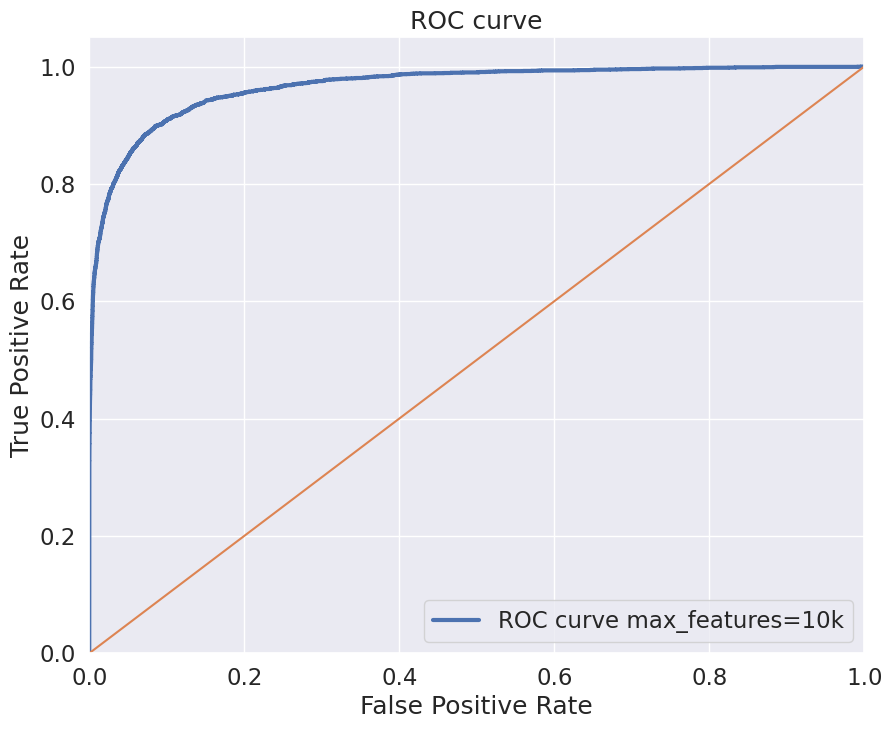

In [15]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))

fpr_10k, tpr_10k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2

plt.plot(fpr_10k, tpr_10k, lw=lw+1, label='ROC curve max_features=10k')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

Как это интерпетировать? Давайте построим матрицу ошибок, чтобы стало понятнее

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 1000x800 with 0 Axes>

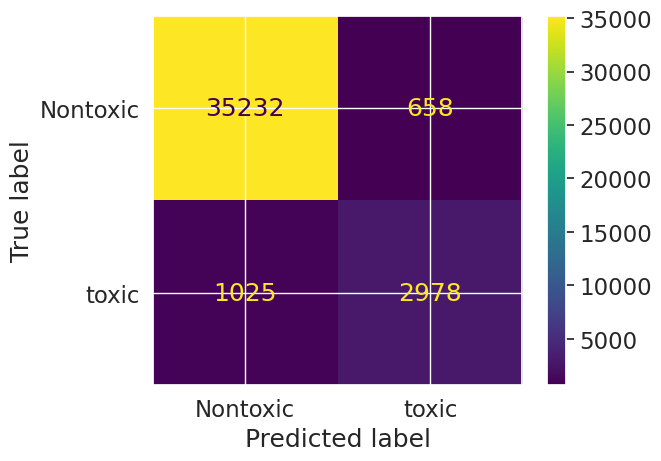

In [17]:
# мы уже нашли ранее оптимальный порог, когда максимизировали f_score
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Nontoxic', 'toxic'])
disp.plot();

Посчитаем FPR, TPR

In [18]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [19]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
TPR, FPR, TNR

(0.7439420434673994, 0.018333797715241015, 0.981666202284759)

Глобальные выводы:

1. TNR = 0.98 -> модель находит в 2% нормальных комментариев видит токсичные комментарии.
2. TPR = 0.74 -> модель находит 74% токсичных комментариев из всех токсичных
3. FPR = 0.018 -> модель допускает только 1.8% неверных срабатываний на нормальных комментариях



Пусть:

- пропущенный токсичный комментарий стоит 100р (FN)
- отброшеный пользователь обойдется в 10р (FP)

Определим где больше потерь:


In [20]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
FN = cnf_matrix[1][0]
FP = cnf_matrix[0][1]

pay_toxic = FN * 100 + FP * 10
print('порог: ', thresholds[ix], '  потери:', pay_toxic)

порог:  0.2734990550017266   потери: 109080


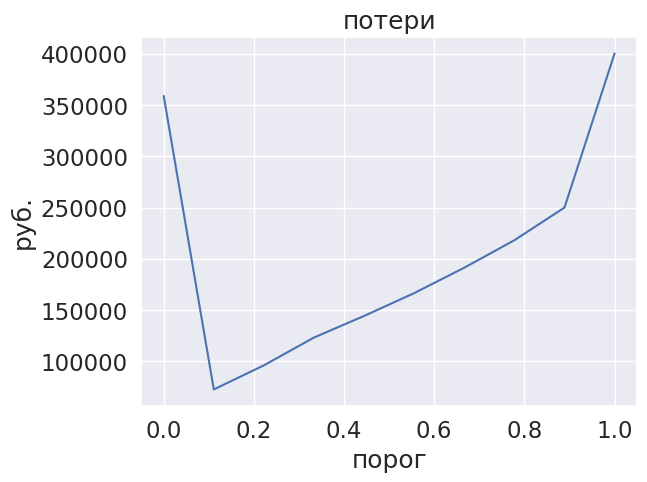

In [21]:
pay_toxic_th = []
trh_level = np.linspace(0, 1, 10).tolist()

for trh in trh_level:
    cnf_matrix = confusion_matrix(y_test, y_score > trh)
    FN = cnf_matrix[1][0]
    FP = cnf_matrix[0][1]
    pay_toxic_th.append(FN * 100 + FP * 10)

plt.plot(trh_level, pay_toxic_th)
plt.ylabel('руб.')
plt.xlabel('порог')
plt.title('потери')
plt.show()

<Figure size 1000x800 with 0 Axes>

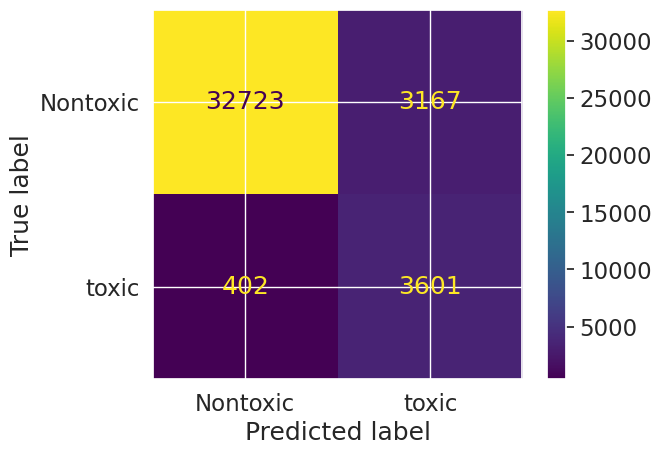

In [22]:
cnf_matrix = confusion_matrix(y_test, y_score > 0.1)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['Nontoxic', 'toxic'])
disp.plot();

In [23]:
cnf_matrix = confusion_matrix(y_test, y_score > 0.1)
FN = cnf_matrix[1][0]
FP = cnf_matrix[0][1]


pay_toxic = FN * 100 + FP * 10
print('порог: ', 0.1, '  потери:', pay_toxic)

порог:  0.1   потери: 71870


## Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В идеале бы конечно всех людей отправить на обследования, но количество тестов ограничено, бюджет ограничен, поэтому нужно отбирать только тех людей, у которых повышен риск сердечно-сосудистых заболеваний.

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:



Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол


Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза


Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность


Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

Ссылка на google drive: https://drive.google.com/file/d/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G

In [24]:
!wget 'https://drive.google.com/uc?&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2024-04-25 08:24:20--  https://drive.google.com/uc?&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 64.233.180.113, 64.233.180.101, 64.233.180.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.180.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G [following]
--2024-04-25 08:24:20--  https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941524 (2.8M) [application/octet-stream]
Saving to: ‘train_case2.csv’

train_case2.csv     100%[===================>]   2.80M  --.-KB/s    in 0.04s   

2024-04-25 08:24:20 (68.8 M

In [25]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [26]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'),
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [27]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [28]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [29]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='f1')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7105875496743822+-0.00427610234814645


Посчитаем precision/recall/f_score

In [30]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147378, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую.

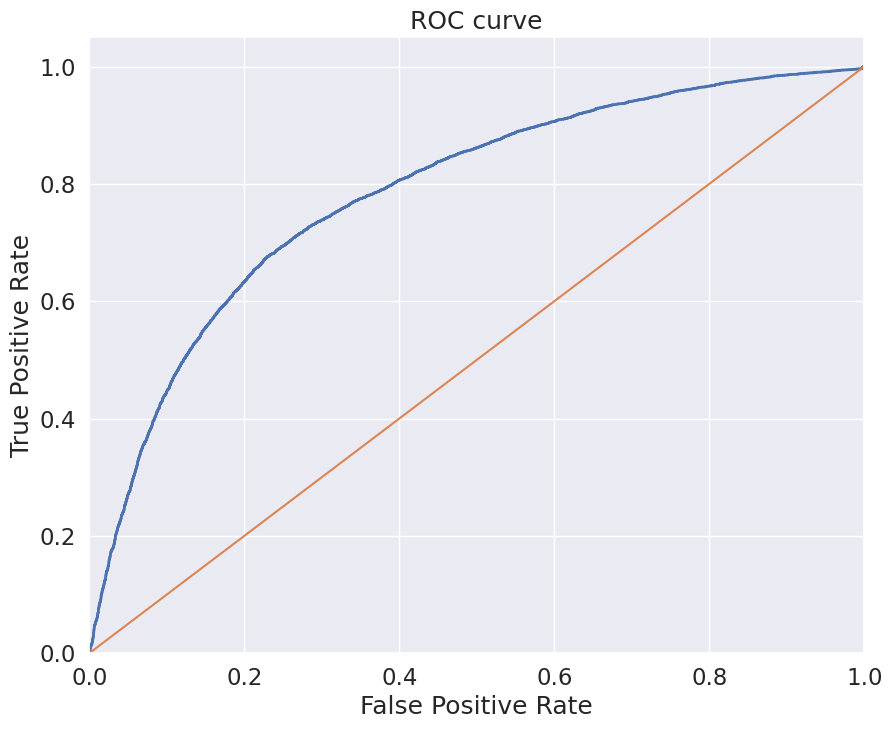

In [31]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

print(f"roc auc score: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}")

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852


Посмотрим на матрицу ошибок

<Figure size 1000x800 with 0 Axes>

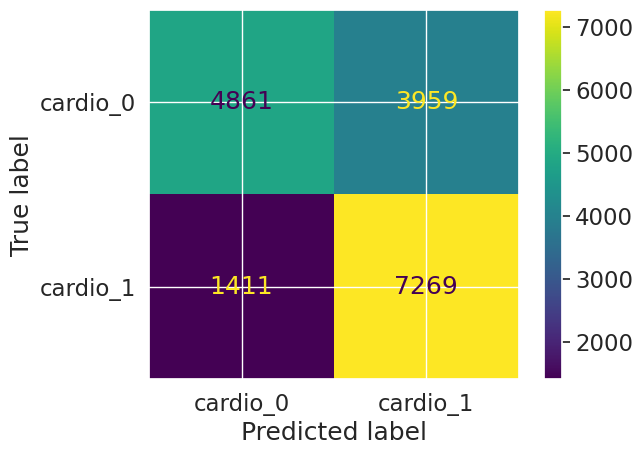

In [33]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['cardio_0', 'cardio_1'])
disp.plot();

Посчитаем FPR, TPR

In [34]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов здоровых пациентов получат метку 1.


Пусть:

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р



- лишних тестов сделали FP = cnf_matrix[0][1]
- пропустили больных FN = cnf_matrix[1][0]
- правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:


In [35]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [36]:
rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000




Расходы, если сделать тест всем:


In [37]:
rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)

расходы, если делать тест всем и лечить группу большых: 154700000




Расходы если использовать ML:


In [38]:
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152974200




Оценим разницу:


In [39]:
print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

Расходы "решение не делать тесты - расходы с МL:" 20625800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1725800




Метрика по деньгам : получить меньше расходов чем при полном тесте

In [40]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100,
                                 rubl_early_treatment=100,
                                 rubl_late_treatment=1000):
    business_threshold = 0

    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнес показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    print('расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если использовать МЛ: 152712400


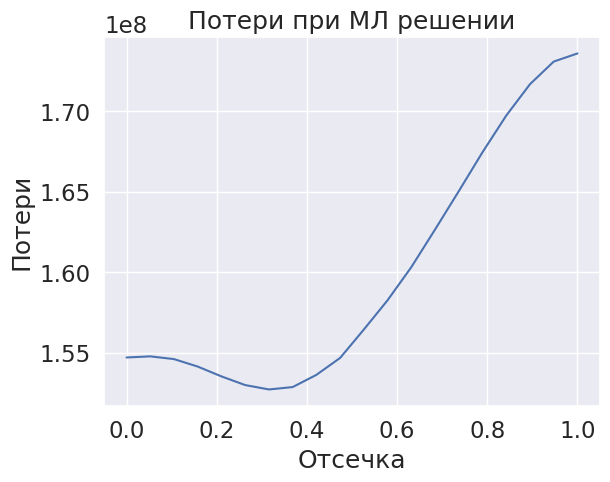

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3869370891147378


In [41]:
busines_tr = business_threshold_calibrate(y_test, y_score,
                                          thresholds[ix],
                                          rubl_test=1400,
                                          rubl_early_treatment=15000,
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])

## Кейс 3 - Отток пользователей в онлайн-игре

https://mlbootcamp.ru/ru/round/10/sandbox/

В этой задаче необходимо научиться предсказывать, остается ли участник в он-лайн игре или уходит из нее. Уходом считается отсутствие его в игре в течение недели.



Всего используется 12 признаков, вычисленных за 2 предыдущие недели:

- maxPlayerLevel - максимальный уровень игры, который прошел игрок
- numberOfAttemptedLevels - количество уровней, которые попытался пройти игрок
- attemptsOnTheHighestLevel - число попыток, сделанных на самом высоком уровне
- totalNumOfAttempts - общее число попыток
- averageNumOfTurnsPerCompletedLevel - среднее количество ходов, выполненных на успешно пройденных уровнях
- doReturnOnLowerLevels - делал ли игрок возвраты к игре на уже пройденных уровнях
- numberOfBoostersUsed - количество использованных бустеров
- fractionOfUsefullBoosters - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)
- totalScore - общее количество набранных очков
- totalBonusScore - общее количество набранных бонусных очков
- totalStarsCount - общее количество набранных звезд
- numberOfDaysActuallyPlayed - количество дней, когда пользователь играл в игру

Все предоставленные для задачи данные разбиты на две части: обучающую (x_train.csv и y_train.csv) и тестовую (x_test.csv). Каждая строка файлов x_train.csv и x_test.csv соответствует одному пользователю. Данные в строке разделены точкой с запятой. Первая строка содержит имена признаков. Файл y_train.csv содержит значения 1 или 0 в зависимости от того, остался пользователь в игре или вышел из нее соответственно.

Как обучающая (x_train.csv и y_train.csv), так и тестовая (x_test.csv) выборки содержат информацию о 25289 пользователях.

Решение победителя https://habr.com/ru/post/324916/ (немного адаптированное)

In [97]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

Ссылки на google drive:
1. https://drive.google.com/file/d/1LfYcW-_9eHg7JIKmR8K9xjmU-npjMXTN
2. https://drive.google.com/file/d/1OZqSfha02EAs33ZdV6ZdZH5T7qF8J9mz

In [98]:
!wget 'https://drive.google.com/uc?id=1OZqSfha02EAs33ZdV6ZdZH5T7qF8J9mz' -O x_train.csv
!wget 'https://drive.google.com/uc?id=1LfYcW-_9eHg7JIKmR8K9xjmU-npjMXTN' -O y_train.csv

--2024-04-25 09:01:48--  https://drive.google.com/uc?id=1OZqSfha02EAs33ZdV6ZdZH5T7qF8J9mz
Resolving drive.google.com (drive.google.com)... 172.253.122.100, 172.253.122.102, 172.253.122.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OZqSfha02EAs33ZdV6ZdZH5T7qF8J9mz [following]
--2024-04-25 09:01:48--  https://drive.usercontent.google.com/download?id=1OZqSfha02EAs33ZdV6ZdZH5T7qF8J9mz
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1164788 (1.1M) [application/octet-stream]
Saving to: ‘x_train.csv’

x_train.csv         100%[===================>]   1.11M  --.-KB/s    in 0.03s   

2024-04-25 09:01:49 (31.9 MB

In [99]:
all_train = pd.read_csv('x_train.csv', sep=';')
all_target = pd.read_csv('y_train.csv', sep=';', names=['TARGET'])
all_train['TARGET'] = all_target['TARGET']

In [100]:
all_train = all_train.drop_duplicates()

In [101]:
all_train

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,TARGET
0,39,10,3,17,24.444444,1,5,0.400000,2650000,1375,21,2,0
1,21,22,19,55,17.045455,1,6,0.333333,5614000,3825,51,4,1
2,5,6,1,6,8.400000,0,1,1.000000,857000,1150,14,1,1
3,21,2,5,6,19.000000,0,1,0.000000,120000,0,1,1,1
4,4,5,1,5,9.600000,0,1,1.000000,857000,1075,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25283,12,13,1,14,15.416667,0,3,0.666667,3470000,2475,32,1,0
25284,3,4,1,4,7.000000,0,0,0.000000,800000,1000,9,1,0
25285,8,9,1,9,14.000000,0,3,1.000000,1833000,1775,19,1,0
25286,6,7,2,9,10.571429,0,2,0.500000,1483000,1375,16,1,1


In [116]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(all_train.drop(columns=['TARGET']),
                                                    all_train['TARGET'],
                                                    random_state=0,
                                                    stratify=all_train['TARGET'])

In [117]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(TARGET
 0    0.667832
 1    0.332168
 Name: proportion, dtype: float64,
 TARGET
 0    0.667893
 1    0.332107
 Name: proportion, dtype: float64)

In [118]:
from sklearn.preprocessing import MinMaxScaler

# выборки для разных моделей
scaler_reg = MinMaxScaler()
scaler_reg.fit(X_train)
X_train = scaler_reg.transform(X_train)
X_test = scaler_reg.transform(X_test)

In [119]:
%%time

import xgboost as xgb

params = {
    'max_depth': 4,
    'eta': 0.01,
}

bst1 = xgb.XGBClassifier(**params)
bst1.fit(X_train, y_train)

CPU times: user 2.82 s, sys: 5.85 ms, total: 2.83 s
Wall time: 3.1 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [136]:
%%time
from sklearn.ensemble import RandomForestClassifier

params_est = {
    'n_estimators': 100,
    'random_state': 1,
}
bst2 = RandomForestClassifier(**params_est)
bst2.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 1.54 ms, total: 3.86 s
Wall time: 6.37 s


RandomForestClassifier(random_state=1)

In [137]:
# обычная логистическая регрессия
bst3 = LogisticRegression()
bst3.fit(X_train, y_train)

LogisticRegression()

Посчитаем скоры

In [138]:
t1 = bst1.predict_proba(X_test)[:, 1]
t2 = bst2.predict_proba(X_test)[:, 1]
t3 = bst3.predict_proba(X_test)[:, 1]

Объединим все

In [142]:
results = pd.DataFrame({
    'y_true': y_test,
    'XGB': t1,
    'RF': t2,
    'LR': t3
})

results['AVG_xgb_rf_lr'] = results[['XGB', 'RF', 'LR']].mean(axis=1)
results['AVG_xgb_rf'] = results[['XGB', 'RF']].mean(axis=1)
results['AVG_xgb_lr'] = results[['XGB', 'LR']].mean(axis=1)
results

,y_true,XGB,RF,LR,AVG_xgb_rf_lr,AVG_xgb_rf,AVG_xgb_lr
12362,0,0.154345,0.00,0.096279,0.083541,0.077173,0.125312
24521,0,0.371748,0.43,0.311995,0.371248,0.400874,0.341871
6381,0,0.154345,0.03,0.093456,0.092600,0.092173,0.123900
10157,0,0.587161,0.84,0.763728,0.730296,0.713581,0.675444
1351,0,0.154345,0.03,0.102694,0.095680,0.092173,0.128520
...,...,...,...,...,...,...,...
16724,0,0.165642,0.03,0.142003,0.112548,0.097821,0.153822
23869,1,0.206689,0.16,0.151076,0.172588,0.183345,0.178883
12258,1,0.545017,0.81,0.573277,0.642764,0.677508,0.559147
24472,1,0.219230,0.15,0.173946,0.181059,0.184615,0.196588


Посчитаем метрики

In [143]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    return thresholds[ix]

In [144]:
xgb_th = get_metrics(results['XGB'])
gbm_th = get_metrics(results['RF'])
lr_th = get_metrics(results['LR'])
blending_th = get_metrics(results['AVG_xgb_rf_lr'])
blending1_th = get_metrics(results['AVG_xgb_rf'])
blending2_th = get_metrics(results['AVG_xgb_lr'])

Best Threshold=0.3607120215892792, F-Score=0.716, Precision=0.672, Recall=0.765
Best Threshold=0.4, F-Score=0.693, Precision=0.646, Recall=0.748
Best Threshold=0.31659374285056174, F-Score=0.708, Precision=0.673, Recall=0.747
Best Threshold=0.3530571412928787, F-Score=0.714, Precision=0.668, Recall=0.766
Best Threshold=0.3770766788721085, F-Score=0.708, Precision=0.661, Recall=0.761
Best Threshold=0.3326302080912994, F-Score=0.714, Precision=0.671, Recall=0.762


Ничего особенного блендинг нам не дает, но вполне возможно, что при большем количестве моделей результат может быть иным.

Обработка экономики процесса: Удержание одного пользователя у нас уйдет 1 рубль. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 рубля.

In [151]:
cnf_matrix = confusion_matrix(y_test, results['XGB'] > xgb_th)
cnf_matrix

array([[2982,  650],
       [ 447, 1359]])

In [152]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

In [153]:
add_summ = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
print('дополнительный доход: ', add_summ)

дополнительный доход:  709




У нас все хорошо, Мы в "+". В этот момент главный вопрос, сколько стоит привлечение. Возможно оно дешевле удержания.

Модель нужно откалибровать по сумме add_summ (максимизация )


In [155]:
def get_rubles(y_test, probs):

    add_summ = []
    thresholds = np.linspace(0, 1, 100)
    for i in thresholds:
        cnf_matrix = confusion_matrix(y_test, probs > i)
        add_summ.append(cnf_matrix[1,1] * 2 - np.sum(cnf_matrix[:,1]) * 1)

    # locate the index of the largest f score
    ix = np.argmax(add_summ)
    print('Best Threshold=%.3f, sum=%.3f'%(thresholds[ix], add_summ[ix]))
    return thresholds[ix]


tr = get_rubles(y_test, results['XGB'])

Best Threshold=0.475, sum=767.000


In [158]:
from sklearn.model_selection import GridSearchCV


def my_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    TP = cnf_matrix[1][1]
    add_summ = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
    return add_summ

params = [
    {'n_estimators': np.arange(50, 150, 10),
     'max_depth': np.arange(2, 10)}
]

gs = GridSearchCV(estimator=xgb.XGBClassifier(random_state=1),
                  param_grid=params,
                  cv=5,
                  scoring=my_scorer)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             param_grid=[{'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                          'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])}],
             scoring=<function my_scorer at 0x7d7de43620e0>)

In [163]:
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.084553,0.001109,0.005613,0.000219,3,60,"{'max_depth': 3, 'n_estimators': 60}",453.0,415.0,427.0,480.0,434.0,441.8,22.727956,1
6,0.114617,0.008499,0.005817,0.000160,2,110,"{'max_depth': 2, 'n_estimators': 110}",456.0,415.0,433.0,459.0,442.0,441.0,16.062378,2
0,0.068227,0.006926,0.005101,0.000855,2,50,"{'max_depth': 2, 'n_estimators': 50}",461.0,415.0,423.0,464.0,439.0,440.4,19.652990,3
10,0.081230,0.009697,0.005115,0.000109,3,50,"{'max_depth': 3, 'n_estimators': 50}",451.0,410.0,428.0,477.0,435.0,440.2,22.622113,4
5,0.104076,0.006861,0.005469,0.000204,2,100,"{'max_depth': 2, 'n_estimators': 100}",460.0,417.0,424.0,458.0,441.0,440.0,17.378147,5


In [164]:
params = {'max_depth': 3, 'n_estimators': 60}
model = xgb.XGBClassifier(random_state=1, **params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [166]:
th_model = get_metrics(model.predict_proba(X_test)[:, 1])

Best Threshold=0.37786203622817993, F-Score=0.716, Precision=0.674, Recall=0.764


In [167]:
def get_rubles(y_test, probs):

    add_summ = []
    thresholds = np.linspace(0, 1, 100)
    for i in thresholds:
        cnf_matrix = confusion_matrix(y_test, probs > i)
        add_summ.append(cnf_matrix[1,1] * 2 - np.sum(cnf_matrix[:,1]) * 1)

    # locate the index of the largest f score
    ix = np.argmax(add_summ)
    print('Best Threshold=%.3f, sum=%.3f'%(thresholds[ix], add_summ[ix]))
    return thresholds[ix]


tr = get_rubles(y_test, model.predict_proba(X_test)[:, 1])

Best Threshold=0.465, sum=776.000


## Упражнение 🦾

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 10000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 40000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 5000
4. Сделать выводы о том, какая модель справилась с задачей лучше других
5. Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 10000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 40000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 5000

#### Упражнение 🦾 (ответ)

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [74]:
!wget 'https://drive.google.com/uc?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2024-04-25 08:39:54--  https://drive.google.com/uc?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 172.253.63.101, 172.253.63.139, 172.253.63.102, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G [following]
--2024-04-25 08:39:54--  https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.167.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941524 (2.8M) [application/octet-stream]
Saving to: ‘train_case2.csv’

train_case2.csv     100%[===================>]   2.80M  --.-KB/s    in 0.04s   

2024-04-25 08:39:54 (67.3 MB

In [75]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [76]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'),
                                                    df['cardio'], random_state=0)

In [77]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [78]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [79]:
model_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

# обучим пайплайн на всем тренировочном датасете
model_lr.fit(X_train, y_train)

preds = model_lr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147378, F-Score=0.730, Precision=0.647, Recall=0.838


In [80]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7840347790421852

In [81]:
rubl_test = 5000
rubl_early_treatment = 10000
rubl_late_treatment = 40000

In [82]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 185270000


In [83]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'rubl_ML'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML


In [84]:
tmp_res = pd.DataFrame({
    'model': type(model_lr['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, index=[0])

metrics_df = pd.concat([metrics_df, tmp_res], ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,185270000


Модель градиентного бустинга

In [85]:
from sklearn.ensemble import GradientBoostingClassifier


model_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_gb.fit(X_train, y_train)

preds = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.39494659702686624, F-Score=0.740, Precision=0.698, Recall=0.788


In [86]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8026153641179974

In [87]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 191010000


In [88]:
tmp_res = pd.DataFrame({
    'model': type(model_gb['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, index=[0])

metrics_df = pd.concat([metrics_df, tmp_res], ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,185270000
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,191010000


Модель случайного леса

In [89]:
from sklearn.ensemble import RandomForestClassifier

model_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_rf.fit(X_train, y_train)

preds = model_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


In [90]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7710366181802983

In [91]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 190920000


In [92]:
tmp_res = pd.DataFrame({
    'model': type(model_rf['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, index=[0])

metrics_df = pd.concat([metrics_df, tmp_res], ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,185270000
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,191010000
2,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,190920000


2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)


3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
- стоимость лечения 10000р, если сделали тест и начали лечить вовремя
- стоимость лечения 40000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 5000р

4. Сделать выводы о том, какая модель справилась с задачей лучше других

In [93]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,185270000
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,191010000
2,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,190920000


Минимальные расходы

In [94]:
metrics_df.sort_values('rubl_ML')

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,185270000
2,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,190920000
1,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,191010000


5. Найти порог классификации по деньгам для лучшей модели <br>

- стоимость лечения 10000р, если сделали тест и начали лечить вовремя
- стоимость лечения 40000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 5000


In [95]:
def business_threshold_calibrate(y_test, y_score,
                                 rubl_test=100,
                                 rubl_early_treatment=100,
                                 rubl_late_treatment=1000):
    business_threshold = 0
    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)


    print('расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если использовать МЛ: 172525000


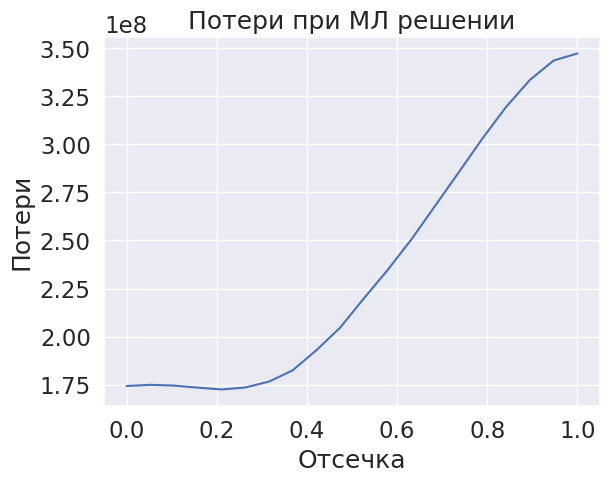

уровень порога по бизнес метрике 0.21052631578947367


In [96]:
busines_tr = business_threshold_calibrate(y_test,
                                          model_lr.predict_proba(X_test)[:, 1],
                                          rubl_test=5000,
                                          rubl_early_treatment=10000,
                                          rubl_late_treatment=40000)

print('уровень порога по бизнес метрике', busines_tr)

## Дополнительные ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic
3. Метрики для классификации (видео) - https://youtube.com/playlist?list=PLkJJmZ1EJno6CLyvD4DHc32Fed6cPBHje
4. Метрики для регрессии (видео) - https://youtu.be/vh2smjQyhp8
5. ROC-AUC (видео) - https://youtu.be/v6PPG8J_Egs